# Grad-CAM Heatmap Sample

|Item|Description|
|---|---|
|DeepLearning Framework|PyTorch|
|Dataset|Food-101|
|Model Architecture|Simple CNN|
|XAI Method|Grad-CAM|


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import numpy as np
import torch

from PIL import Image
from pathlib import Path
from data_loader.data_loader import DataLoader
from models.pytorch import simple_cnn

from explainable_ai.pytorch.explainable_ai import ExplainableAI

## Prepare Trained-Model

Please prepare the trained model and set the path to `trained_model` variable.  
The example of the way to prepare the trained model is as below.

- Download from [Google Drive](https://drive.google.com/file/d/1n-gMqdDxkc1cpMmQDsKt7wMBrQIO2hHX/view?usp=drive_link)
- Train the model using [002_ImageClassification-Food101-SimpleCNN-PyTorch.ipynb](./002_ImageClassification-Food101-SimpleCNN-PyTorch.ipynb)


In [3]:
trained_model = '../trained_model/002_ImageClassification-Food101-SimpleCNN-PyTorch/model.pth'

## Set Random Seed

In [4]:
seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Device Settings

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Hyperparameters

In [6]:
batch_size = 32

## Load Dataset and Normalize

In [7]:
dataset_dir = '/tmp/dataset'
dataloader = DataLoader('food101_pytorch', dataset_dir, batch_size=batch_size)

In [8]:
dataloader.dataset.class_name

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Load Model

In [9]:
input_size = (batch_size, 3, 128, 128)
num_classes = len(dataloader.dataset.class_name)
model = simple_cnn.SimpleCNN(device, input_size=input_size, num_classes=num_classes)

model.net.load_state_dict(torch.load(trained_model))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 101]                 --
├─Conv2d: 1-1                            [32, 64, 128, 128]        1,792
├─ReLU: 1-2                              [32, 64, 128, 128]        --
├─BatchNorm2d: 1-3                       [32, 64, 128, 128]        128
├─Conv2d: 1-4                            [32, 64, 128, 128]        36,928
├─ReLU: 1-5                              [32, 64, 128, 128]        --
├─BatchNorm2d: 1-6                       [32, 64, 128, 128]        128
├─MaxPool2d: 1-7                         [32, 64, 64, 64]          --
├─Dropout: 1-8                           [32, 64, 64, 64]          --
├─Conv2d: 1-9                            [32, 128, 64, 64]         73,856
├─ReLU: 1-10                             [32, 128, 64, 64]         --
├─BatchNorm2d: 1-11                      [32, 128, 64, 64]         256
├─Conv2d: 1-12                           [32, 128, 64, 64]         147,

<All keys matched successfully>

In [10]:
model.net.eval()

Net(
  (conv3_64): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2d64_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv64_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2d64_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv64_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2d128_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv128_128): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2d128_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv128_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2d256_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv256_256): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2d256_2): BatchNorm2d(256, e

In [11]:
target_layers = [model.net.eval().conv256_256]
target_layers

[Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)]

In [12]:
testloader = dataloader.dataset.testloader
test_pos = 0
output_dir = 'food-101_grad-cam'

for input_tensor, targets in testloader:
    input_images = dataloader.dataset.inverse_normalize(input_tensor).permute(0, 2, 3, 1).to('cpu').numpy()  # convert from NCHW -> NHWC
    image_names = dataloader.dataset.test_file_list[test_pos:test_pos+len(input_tensor)]
    test_pos = test_pos + len(input_tensor)
    
    method = 'grad_cam'
    cam_outputs, cam_images = ExplainableAI(method, model.net, target_layers, input_tensor, input_images, image_names=image_names, output_dir=output_dir)
    

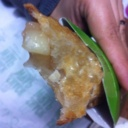

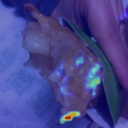

In [13]:
input_image = Image.open(Path(output_dir, 'input_image', dataloader.dataset.test_file_list[0]))
cam_image = Image.open(Path(output_dir, 'cam', dataloader.dataset.test_file_list[0]))
display(input_image, cam_image)